
# Author: Priyanka Prusty

# TASK 0: Import all the necessary packages here

In [1]:
#Import the right packages
import scipy
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# TASK 1: Load .mat file

In [2]:
#Reads the Metadata file and returns the data frame
def readMatFile(filePath):
    metaData = loadmat(filePath)
    mdata = metaData['wiki_labeled']  # variable in mat file
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    df = pd.DataFrame()
    for key in ndata:
        df[key] = pd.Series(ndata[key].flatten(), dtype=ndata[key].dtype)
    return df

df = readMatFile('wiki_labeled.mat')

        

# Task 2: Randomly split the new dataset into 80% training and 20% test sets

In [3]:
#Split data set and reindex all of them for better concatnation
def splitAndReindex(X, y,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
    y_train.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return X_train, X_test, y_train, y_test


#Call the above function
y = df.age
X = df.drop('age', axis=1)
X_train, X_test, y_train, y_test = splitAndReindex(X,y)
print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)

Shape of X_train (48261, 10)
Shape of X_test (12066, 10)


# Task 3: Apply PCA

## Task 3: Step 1. Load 2D faces from train data

In [4]:
#read images and add the image array to existing data frame
def readImages(dataFrame):
    img_array = []
    for path in dataFrame['full_path']:
        absolute_path = 'wiki_labeled/' + path[0]
        img=cv2.imread(absolute_path,cv2.IMREAD_GRAYSCALE)
        img_array.append(img)
    return np.asarray(img_array)

X_train_images = readImages(X_train)

print('shape of each images=',X_train_images[0].shape)

shape of each images= (100, 100)


## Task 3: Step 2. Represent every nxn image in n^2x1 vector

In [5]:
#convert each nxn image to (n)^2x1 image
def reshapeImages(imageArray):
    img_vectors =[]
    for i in range(len(imageArray)): 
        img_vectors.append(imageArray[i].flatten())
    return img_vectors

X_train_images = reshapeImages(X_train_images)
    
print('shape of each vector=',X_train_images[0].shape)

shape of each vector= (10000,)


## Task 3: Step 3. Compute average face vector

In [6]:
image_array = X_train_images
#find the mean
sum = np.zeros((10000,), dtype=int)
for i in range(len(image_array)):
    sum=np.add(sum,image_array[i])
mean_train=sum/len(image_array)
print('mean=',mean_train)

mean= [97.63320279 97.47524917 97.32939641 ... 92.64242349 92.77646547
 93.08795922]


## Task 3: Step 4. Centralize the data

In [7]:
def getCentralizedVector(image_array, mean):
    A = image_array-mean_train
    A = np.asarray(A)
    return A

A= getCentralizedVector(image_array, mean_train)
print('shape of matrix with centerized vector A =',A.shape)

shape of matrix with centerized vector A = (48261, 10000)


## Task 3: Step 5. Find the Covariance matrix

In [8]:
def getCovarianceMatrix(A):
    AT = A.transpose()
    Q = AT.dot(A)
    return Q

Q=getCovarianceMatrix(A)
print('shape of covariance matrix=',Q.shape)

shape of covariance matrix= (10000, 10000)


## Task 3: Step 6. Compute eigenvalues and eigenvectors

In [9]:
#find the eigenvalues and eigenvectors of the covariance matrix
eigvals, eigvecs = scipy.linalg.eigh(Q)
print('showing one eigenvalue=',eigvals[0])
print('showing one eigenvector=',eigvecs[0])

showing one eigenvalue= 63391.3673709917
showing one eigenvector= [ 0.00175833 -0.00151185  0.00292999 ...  0.00698097 -0.01572513
 -0.01191968]


# Task 4: Find K largest eigenvectors by showing a scree plot

## Task 4: Step 1. Sort the eigenvectors based on eigenvalue

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
1134868434028.38
185447266691.56293
140744595399.92657
114020613285.3537
65233238643.345505
48978455030.70975
40141128455.93442
33782987152.743317
33170136370.627876
29910530654.530136
21539453870.463043
20905660680.748314
18001945516.524673
16269051400.7759
15010134403.950777
13276133791.177246
12163023099.512646
11418194007.593792
10470063749.7843
10271154493.35355
9578561031.782326
9046976190.853067
8463953073.302155
7736858046.670494
7451781928.626051
7222666519.61541
6636716182.099783
6152790862.198275
5964293690.305008
5578493468.3292675
5562918703.462147
5429643358.099085
5215876290.685736
5004033245.700148
4846443125.039879
4693381522.070168
4563943649.995241
4393132613.521509
4283533788.8027706
4217571946.874444
4107793724.439766
3899570642.3964143
3762604046.92374
3680817895.351129
3614563337.8662224
3462308881.2695594
3358204355.980122
3304277125.537722
3182243248.8204913
3134632235.767384
3097379736.737599
2991106602.3347454
2905397366.26949

12996293.826260382
12986701.656492691
12972671.76997437
12965676.954641791
12950126.339105286
12944340.131392991
12933764.656849813
12929691.610412043
12918529.762312109
12908812.192704005
12905050.056699762
12896349.954783594
12884920.232934225
12880365.554978838
12867179.792141961
12853828.434128609
12847661.267045923
12836101.275362758
12827021.656374577
12814948.946206404
12810762.08607558
12802774.235315004
12796487.74359352
12772357.128478877
12770250.395073827
12759951.291566009
12753969.041106505
12746947.527152212
12737501.50339052
12730750.814055666
12719784.919716356
12695703.674424075
12692058.684754029
12680262.958415229
12674970.152563933
12663256.870589498
12645623.491399415
12637892.903515276
12636705.869698077
12615055.770403707
12603859.177085219
12596257.996705035
12591005.314316003
12585125.654504817
12573094.09145584
12568325.535164785
12563532.36568076
12556723.951585043
12539660.36939905
12532029.466253234
12521985.888049781
12512940.562502084
12511577.12132659
1

3838799.727114321
3837915.2523702965
3835876.5322560775
3834161.9971343954
3832614.33987176
3831504.837954677
3827562.5078393626
3825720.3156981827
3823703.761178995
3823097.0454744464
3819327.6827323264
3818773.336724998
3814655.66117877
3813360.149596929
3812186.801668363
3808367.8763514548
3806015.2351944563
3803083.841746537
3802368.951951863
3799795.490416176
3797740.7212904203
3796934.8500192915
3795279.6776651223
3792925.3134041536
3791344.7986210114
3789666.9721789914
3786950.407449745
3785098.1178197344
3783968.260375757
3781783.103960126
3781084.220861685
3778100.4682953726
3775627.4046353023
3774439.7261320404
3773284.077511772
3772830.17667363
3768958.5457817954
3768471.1810075385
3766850.948024482
3764601.6371001536
3763788.4289469076
3759723.065847784
3758119.550209117
3756083.8531498224
3753732.9943693304
3752737.4209566717
3750932.7262399276
3747564.48517596
3742674.589913299
3741109.341308614
3740318.3231750424
3738023.040720428
3736687.7967817173
3735792.652358866
373

1431448.2080591088
1430586.126977147
1428972.89748764
1428713.7612256883
1428149.9874625178
1427844.5413034419
1427662.67931609
1427094.054850338
1426227.1874721725
1425314.1866143527
1424986.6079968591
1424637.2603347143
1424298.7114752945
1422875.906754434
1422072.967062506
1421465.4389663967
1420862.1134642437
1419816.7879913654
1418433.3993516099
1417904.792559871
1417365.8711022395
1416740.0057013202
1416172.2840138585
1415360.0984285427
1415043.6898060888
1414765.1275537377
1413464.604097799
1412970.3465965185
1412651.459884218
1412203.7982194894
1411644.9026949606
1410047.5649347478
1409374.7787095387
1409167.9608063889
1408429.6946078865
1407221.1131235175
1406318.5322531322
1405377.914593787
1405181.5585266603
1404696.3378313943
1404224.9803756555
1403435.595270466
1402548.864747499
1402177.422897393
1400998.4638353856
1400495.3428341416
1399813.5796977365
1399582.5537084
1398630.45786794
1397728.0170114194
1396742.1762736873
1396526.4944038605
1396260.582248678
1395465.988783

505670.7416759253
505039.8519552315
504708.4774062757
504402.54617694125
504204.35468360945
504096.7394043758
503644.01048228703
503310.5100561414
503155.64787588175
502842.7456673306
502495.1598463254
502234.3499519689
501987.3298676453
501602.1467456466
501302.33645579475
501140.8035482743
500821.0737969333
500598.0706020843
500268.3941101739
499790.92147107783
499544.8477249134
498982.17991570884
498684.2226315801
498514.17174720136
498200.1954767315
497839.0675146645
497724.69687756675
497390.13094590546
496982.23337452253
496645.07625292544
496289.3131554676
495936.2205891359
495836.8319023495
495120.5250117851
495000.689011237
494894.4888054697
494517.32816681697
493984.1707688819
493761.9729649009
493681.53733279055
493290.2674969209
492605.0159928452
492386.31760207366
492175.2843481491
491892.8972281371
491235.7894444335
491053.80346702575
490603.6626234534
490350.02221686067
490170.51292916085
489926.61717645824
489561.0476634385
489323.43837772147
488738.50182993733
488453.2

## Task 4: Step 2. Draw a scree plot 

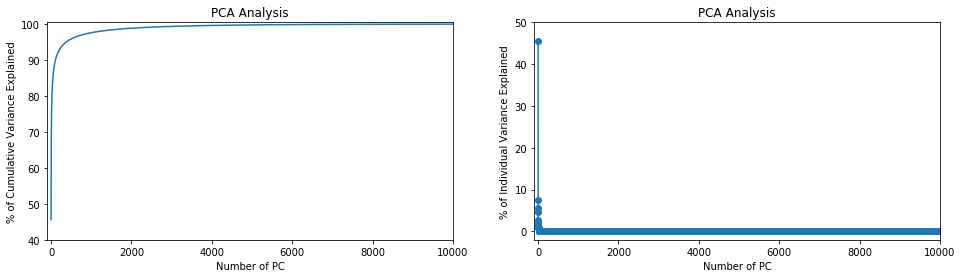

In [11]:
#scree plot

sum_eigvals = np.sum(eigvals)
fig=plt.figure(figsize=(16, 4))
var_exp = [(i / sum_eigvals)*100 for i in sorted(eigvals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

#cumulative variance explained 
fig.add_subplot(1, 2, 1)
plt.ylabel('% of Cumulative Variance Explained')
plt.xlabel('Number of PC')
plt.title('PCA Analysis')
plt.ylim(40,100.5)
plt.xlim(-100,10000)
plt.plot(cum_var_exp)

#individual variance explined towards PC
fig.add_subplot(1, 2, 2)
plt.ylabel('% of Individual Variance Explained')
plt.xlabel('Number of PC')
plt.title('PCA Analysis')
plt.ylim(-2,50)
plt.xlim(-100,10000)
plt.plot(var_exp,'-o')
plt.show()

In [12]:
#I have Choosen k=2500 and got RMSE =22.074205340746495
#for testing I am using k=100
topK=100

# Task 5: Show the top 20 ghosts (i.e., eigenfaces) in a 10x10 grid

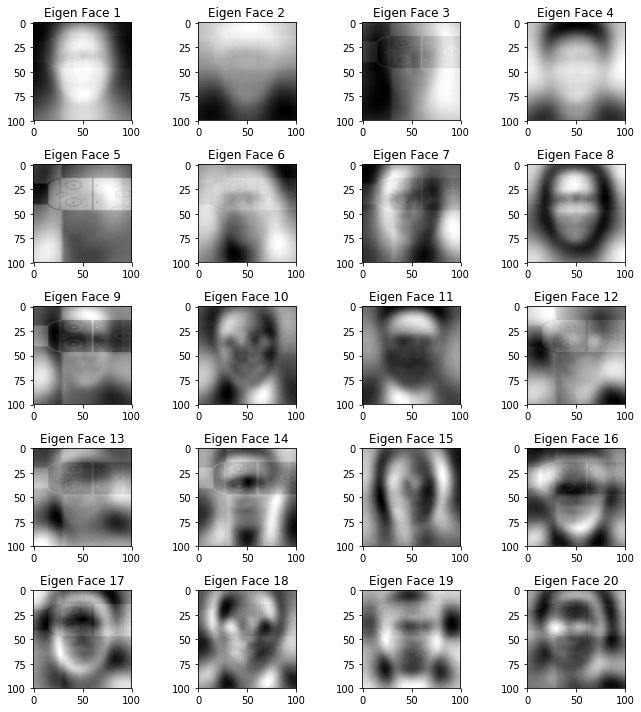

In [13]:
#showing top 20 eigenface
w=10
h=10
fig=plt.figure(figsize=(w, h))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    face=np.reshape(eig_pairs[i][1],(100,100), order='A')
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title('Eigen Face ' + str(i))
    plt.imshow(face,cmap='gray')
    plt.tight_layout()
plt.show()


# Task 6: Considering the chosen K value , project the training and test images on to the eigenfaces to reduce the dimensionality.


In [14]:
#project Train dataset using chosen k value(TopK)  
def projectEigenFaces(A, K):
    omega=[]
    for i in range(len(A)):
        w=[]
        for j in range(K):
            eig_face=eig_pairs[j][1]
            w.append(np.dot(eig_face.T,A[i]))
        omega.append(w)
    return omega

#train with reduced dimensionality
omega_train = projectEigenFaces(A,topK)

In [15]:
#Create a data-frame for variables with reduced dimension
def createADataFrameOmega(omega):
    columns_list=[]
    for i in range(len(omega_train[1])):
        columnStr = 'w_' + str(i)
        columns_list.append(columnStr)
    df_omega = pd.DataFrame(omega, columns=columns_list)
    return df_omega

X_trainOmega = createADataFrameOmega(omega_train)

In [16]:
##project Test dataset using chosen k value(TopK) 
#Read the images
X_test_images = readImages(X_test)
#nxn image to n^2x1 vector
image_array = reshapeImages(X_test_images)
#cetralize the vectors using mean of train
B = getCentralizedVector(image_array, mean_train)
#test with reduced dimensionality
omega_test = projectEigenFaces(B,topK)
X_testOmega = createADataFrameOmega(omega_test)

# Task 7: Perform Stochastic gradient descent (SGD) based linear regression on the training dataset to learn “age”.


In [17]:
#stochastic gradient descent 
def shuffle(X, y):
    r = np.random.permutation(len(y))
    return X[r], y[r]

def linear_regression_sgd(X, y, alpha=0.00001, n_epoch=1000):
    X = np.insert(X, 0, 1, axis=1)
    w = np.zeros(X.shape[1])
    for _ in range(n_epoch):
        X, y = shuffle(X, y)
        for x, target in zip(X, y):
            output = x.dot(w)
            error =  output -target
            w =  w - alpha * error * x
    return w   

def predict(x, thetas):
    x = np.insert(x, 1, 1, axis=1)
    return np.dot(x, thetas)


## Task 7: Step 1. Normalize Train variables

In [18]:
#Normalize X_train
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_trainOmega)
#y_train_int = y_train.astype(int)

## Task 7: Step 2. Apply SGD based linear regression to fit train data

In [19]:
#apply sgd to get the coefficients
w = linear_regression_sgd(X_train_norm, y_train)


## Task 7: Step 3. Normalize test variables

In [20]:
##Now Normalize the Test set
X_test_norm = scaler.transform(X_testOmega)


# Task 8: Predict the test dataset (from Task 2) based on the learned model in Task 7, and report Root Mean Square Error (RMSE).

In [21]:
#Predict the age on test data
y_pred = predict(X_test_norm, w)

In [22]:
#calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse_testing = []
rmse_current = math.sqrt(mse)
rmse_testing.append(rmse_current)
print('RMSE (Testing) sgd = ', rmse_current)

RMSE (Testing) sgd =  20.99869267760899


# Task 9: Using the best regression model, predict age of each of the 2001 facial image in wiki_judge_image dataset, and prepare a submission.csv file.

In [23]:
##Now prepare the Judge set
#Read the mat file
def readJudgeMatFile(filePath):
    metaData = loadmat(filePath)
    mdata = metaData['wiki_judgeX']  # variable in mat file
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    df = pd.DataFrame()
    for key in ndata:
        df[key] = pd.Series(ndata[key].flatten(), dtype=ndata[key].dtype)
    return df

df_judge = readJudgeMatFile('wiki_judgeX.mat')
#Read the images
def readImagesJudge(dataFrame):
    img_array = []
    for path in dataFrame['full_path']:
        absolute_path = 'wiki_judge_images/' + path[0]
        img=cv2.imread(absolute_path,cv2.IMREAD_GRAYSCALE)
        img_array.append(img)
    return np.asarray(img_array)

X_judge_images = readImagesJudge(df_judge)
#nxn image to n^2x1 vector
image_array = reshapeImages(X_judge_images)
#cetralize the vectors using mean of train
C = getCentralizedVector(image_array, mean_train)
#wiki_judge variables with reduced dimensionality
omega_judge = projectEigenFaces(C,topK)
#wiki_judge dataframe
X_JudgeOmega = createADataFrameOmega(omega_judge)
#Normalize wiki_judge variables
X_Judge_norm = scaler.transform(X_JudgeOmega)
#Predict the age on wiki_judge data
y_pred = predict(X_Judge_norm, w)


In [24]:
#Save the file to disk
file_handler = open('judge-submission-run8.csv', 'w')
file_handler.write('ID,age\n')
for i in range(0, len(y_pred)):
    file_handler.write('%d,%f\n' % (i+1, y_pred[i]))

file_handler.close()

# Task 10: Repeat Tasks 2-8 four more times, and report average RMSE and standard deviation of the RMSE. 

In [25]:
for j in range(4):
    #split
    X_train, X_test, y_train, y_test = splitAndReindex(X,y)
    #read train images
    X_train_images = readImages(X_train)
    #reshape images
    image_array = reshapeImages(X_train_images)
    #find the mean
    sum = np.zeros((10000,), dtype=int)
    for i in range(len(image_array)):
        sum=np.add(sum,image_array[i])
    mean_train=sum/len(image_array)
    #centralize train
    A= getCentralizedVector(image_array, mean_train)
    #find Covariance matrix
    Q=getCovarianceMatrix(A)  
    #calculate eigenvalue and eigen vectors
    eigvals, eigvecs = scipy.linalg.eigh(Q)
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()
    #project train
    omega_train = projectEigenFaces(A,topK)
    #train dataframe
    X_trainOmega = createADataFrameOmega(omega_train)
    #normalize train
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_trainOmega)
    #apply sgd
    w = linear_regression_sgd(X_train_norm, y_train)
    
    ## Now prep test
    #Read the images
    X_test_images = readImages(X_test)
    #reshape test
    image_array = reshapeImages(X_test_images)
    #centralize test
    B = getCentralizedVector(image_array, mean_train)
    #project test
    omega_test = projectEigenFaces(B,topK)
    #Test dataframe
    X_testOmega = createADataFrameOmega(omega_test)
    #normalize test
    X_test_norm = scaler.transform(X_testOmega)
    #Predict the age on test
    y_pred = predict(X_test_norm, w)
    #calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse_current = math.sqrt(mse)
    rmse_testing.append(rmse_current)
    outputString = "RMSE (Testing) using SGD for iteration %d is %f " % ((j+1),rmse_current)
    print(outputString)
    

    

RMSE (Testing) using SGD for iteration 1 is 21.582604 
RMSE (Testing) using SGD for iteration 2 is 21.267757 
RMSE (Testing) using SGD for iteration 3 is 21.805778 
RMSE (Testing) using SGD for iteration 4 is 20.762266 


In [26]:
#average RMSE and stdev of all 5 RMSE calculated above
average_rmse = np.mean(rmse_testing)
stdev_rmse = np.std(rmse_testing)
print("Average(RMSE_test) = ", average_rmse)
print("Stdev(RMSE_test) = ", stdev_rmse)
print ("Ultimate RMSE(testing) =",average_rmse,u"\u00B1",stdev_rmse )


Average(RMSE_test) =  21.28341942728349
Stdev(RMSE_test) =  0.378228880460083
Ultimate RMSE(testing) = 21.28341942728349 ± 0.378228880460083


# Task 11: Draw a plot (K vs RMSE) after experimenting with Tasks 2-8 by varying values of K set {2, 10, 20, 40, 50, 60, 80, 100, 200}

In [27]:
#split
X_train, X_test, y_train, y_test = splitAndReindex(X,y)
#read train images
X_train_images = readImages(X_train)
#reshape images
image_array = reshapeImages(X_train_images)
#find the mean
sum = np.zeros((10000,), dtype=int)
for i in range(len(image_array)):
    sum=np.add(sum,image_array[i])
mean_train=sum/len(image_array)
#centralize train
A= getCentralizedVector(image_array, mean_train)
#find Covariance matrix
Q=getCovarianceMatrix(A)  
#calculate eigenvalue and eigen vectors
eigvals, eigvecs = scipy.linalg.eigh(Q)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()


topKSet = [2, 10, 20, 40, 50, 60, 80, 100, 200]
rmse_topKVar = {}
for topK in topKSet:   
    #project train
    omega_train = projectEigenFaces(A,topK)
    #train dataframe
    X_trainOmega = createADataFrameOmega(omega_train)
    #normalize train
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_trainOmega)
    #apply sgd
    w = linear_regression_sgd(X_train_norm, y_train)
    
    ## Now prep test
    #Read the images
    X_test_images = readImages(X_test)
    #reshape test
    image_array = reshapeImages(X_test_images)
    #centralize test
    B = getCentralizedVector(image_array, mean_train)
    #project test
    omega_test = projectEigenFaces(B,topK)
    #Test dataframe
    X_testOmega = createADataFrameOmega(omega_test)
    #normalize test
    X_test_norm = scaler.transform(X_testOmega)
    #Predict the age on test
    y_pred = predict(X_test_norm, w)
    #calculate RMSE
    mse = mean_squared_error(y_test, y_pred)
    rmse_current = math.sqrt(mse)
    rmse_topKVar[topK] = rmse_current
    outputString = "RMSE (Testing) using SGD for K=%d is %f " % (topK,rmse_current)
    print(outputString)
    

RMSE (Testing) using SGD for K=2 is 25.466382 
RMSE (Testing) using SGD for K=10 is 23.875034 
RMSE (Testing) using SGD for K=20 is 22.236553 
RMSE (Testing) using SGD for K=40 is 21.175715 
RMSE (Testing) using SGD for K=50 is 20.997464 
RMSE (Testing) using SGD for K=60 is 20.932254 
RMSE (Testing) using SGD for K=80 is 20.786390 
RMSE (Testing) using SGD for K=100 is 20.738937 
RMSE (Testing) using SGD for K=200 is 20.669516 


## Task 11 Step 2: Plot RMSE vs K

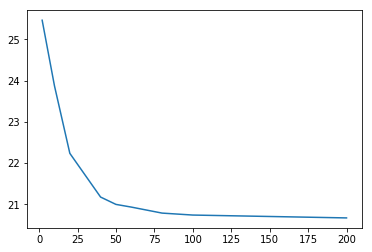

In [28]:
rmse_topKList = sorted(rmse_topKVar.items()) # sorted by key, return a list of tuples

x_axis, y_axis = zip(*rmse_topKList) # unpack a list of pairs into two tuples

plt.plot(x_axis, y_axis)
plt.show()

# Task 12: Kaggle submission

# Task 13: Discard outliers from the given dataset

## Task 13: Step 1. Repeat Task 2-8 removing outliers

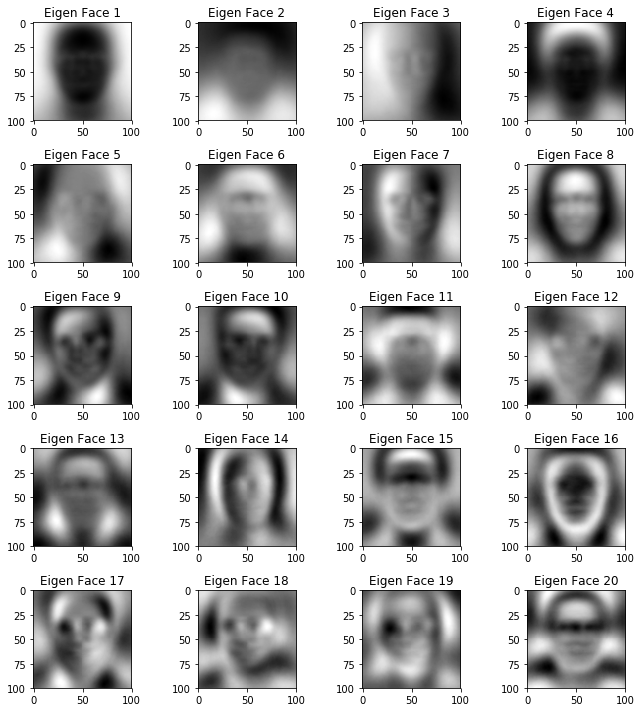

RMSE (Testing) sgd  without outliers =  17.270367190274428


In [29]:
#drop the images with face_score=-inf as part of removing outliers
def cleanOutliners(df):
    return df[df.face_score != np.NINF]

#Filter the outliers with face_score <= 3
def filterMoreOutliers(df):
    return df[df.face_score > 3]

#drop the images with face_score=-inf

df2 = cleanOutliners(df)
#df2 = filterMoreOutliers(df2)
y = df2.age
X = df2.drop('age', axis=1)

#split
X_train, X_test, y_train, y_test = splitAndReindex(X,y)
#read train images
X_train_images = readImages(X_train)
#reshape images
image_array = reshapeImages(X_train_images)
#find the mean
sum = np.zeros((10000,), dtype=int)
for i in range(len(image_array)):
    sum=np.add(sum,image_array[i])
mean_train=sum/len(image_array)
#centralize train
A= getCentralizedVector(image_array, mean_train)
#find Covariance matrix
Q=getCovarianceMatrix(A)  
#calculate eigenvalue and eigen vectors
eigvals, eigvecs = scipy.linalg.eigh(Q)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

#show eigenfaces after outlier removal
w=10
h=10
fig1=plt.figure(figsize=(w, h))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    face=np.reshape(eig_pairs[i][1],(100,100), order='A')
    #img = np.random.randint(10, size=(h,w))
    fig1.add_subplot(rows, columns, i)
    plt.title('Eigen Face ' + str(i))
    plt.imshow(face,cmap='gray')
    plt.tight_layout()
plt.show()

topK=150

#project train
omega_train = projectEigenFaces(A,topK)
#train dataframe
X_trainOmega = createADataFrameOmega(omega_train)
#normalize train
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_trainOmega)
#apply sgd
w = linear_regression_sgd(X_train_norm, y_train)

## Now prep test
#Read the images
X_test_images = readImages(X_test)
#reshape test
image_array = reshapeImages(X_test_images)
#centralize test
B = getCentralizedVector(image_array, mean_train)
#project test
omega_test = projectEigenFaces(B,topK)
#Test dataframe
X_testOmega = createADataFrameOmega(omega_test)
#normalize test
X_test_norm = scaler.transform(X_testOmega)
#Predict the age on test
y_pred = predict(X_test_norm, w)
#calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse_current = math.sqrt(mse)
rmse_testing.append(rmse_current)
print('RMSE (Testing) sgd  without outliers = ', rmse_current)






## Task 13: Step 2. Repeat task 9 to predict on wiki_judge_images

In [30]:
#Read the mat file
df_judge = readJudgeMatFile('wiki_judgeX.mat')
#Read the images
X_judge_images = readImagesJudge(df_judge)
#nxn image to n^2x1 vector
image_array = reshapeImages(X_judge_images)
#cetralize the vectors using mean of train
C = getCentralizedVector(image_array, mean_train)
#wiki_judge variables with reduced dimensionality
omega_judge = projectEigenFaces(C,topK)
#wiki_judge dataframe
X_JudgeOmega = createADataFrameOmega(omega_judge)
#Normalize wiki_judge variables
X_Judge_norm = scaler.transform(X_JudgeOmega)
#Predict the age on wiki_judge data
y_pred = predict(X_Judge_norm, w)

#Save the file to disk
file_handler = open('judge-submission-run10.csv', 'w')
file_handler.write('ID,age\n')
for i in range(0, len(y_pred)):
    file_handler.write('%d,%f\n' % (i+1, y_pred[i]))

file_handler.close()



# Task 14: Implement mini-batch gradient descent

In [31]:
def linear_regression_mbgd(X, y, alpha=0.0001, n_epoch=100, batch_size=200):
    X = np.insert(X, 0, 1, axis=1)
    w = np.zeros(X.shape[1])
    for _ in range(n_epoch):
        X, y = shuffle(X, y)
        m=len(y)
        for i in range(0, m,  batch_size):
            X_i = X[i:i + batch_size]
            y_i = y[i:i + batch_size]
            output = np.dot(X_i, w)
            error = y_i - output
            w = w + alpha * X_i.T.dot(error)
    return w   


In [32]:
#apply regression on X_train using minibatch gradient descent
w_mbgd = linear_regression_mbgd(X_train_norm, y_train)
#Predict age on test data
y_pred = predict(X_test_norm, w_mbgd)
#Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse_current = math.sqrt(mse)
print('RMSE mbgd = ', rmse_current)


RMSE mbgd =  17.24339201946057
